In [2]:
"""
Yelp Review Sentiment Analysis with LSTM & DistilBERT
"""

import os
import logging
import warnings
from dataclasses import dataclass
from typing import Tuple, Dict, List, Optional
import json

# Core libraries
import tensorflow as tf
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import re

# Deep learning libraries
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import torch.nn.functional as F

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Interpretability
try:
    from lime import lime_text
    LIME_AVAILABLE = True
except ImportError:
    LIME_AVAILABLE = False
    warnings.warn("LIME not available. Install with: pip install lime")

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Suppress warnings
warnings.filterwarnings('ignore', category=FutureWarning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
@dataclass
class Config:
    """Configuration class for hyperparameters and settings"""
    # Data parameters
    test_size: float = 0.2
    val_size: float = 0.1
    random_state: int = 42

    # Text processing
    vocab_size: int = 15000  # Increased for better vocabulary coverage
    max_length: int = 128
    min_text_length: int = 5  # Minimum text length after cleaning

    # LSTM parameters
    lstm_embedding_dim: int = 128
    lstm_units_1: int = 64
    lstm_units_2: int = 32
    lstm_dense_units: int = 32
    lstm_dropout_1: float = 0.5
    lstm_dropout_2: float = 0.3
    lstm_epochs: int = 15
    lstm_batch_size: int = 64
    lstm_patience: int = 3

    # BERT parameters
    bert_model_name: str = 'distilbert-base-uncased'
    bert_max_length: int = 128
    bert_epochs: int = 3
    bert_train_batch_size: int = 16
    bert_eval_batch_size: int = 64
    bert_learning_rate: float = 2e-5
    bert_warmup_steps: int = 500

    # Visualization
    figsize: Tuple[int, int] = (12, 8)
    dpi: int = 100

class TextPreprocessor:
    """Enhanced text preprocessing with better cleaning and validation"""

    def __init__(self, min_length: int = 5):
        self.min_length = min_length

    @staticmethod
    def clean_text(text: str) -> str:
        """Enhanced text cleaning with better preprocessing"""
        if pd.isna(text) or not isinstance(text, str):
            return ""

        # Convert to lowercase
        text = text.lower()

        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

        # Remove email addresses
        text = re.sub(r'\S+@\S+', '', text)

        # Remove extra whitespace and special characters
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
        text = re.sub(r'\s+', ' ', text)

        return text.strip()

    @staticmethod
    def classify_sentiment(rating: float) -> str:
        """Enhanced sentiment classification with validation"""
        if pd.isna(rating):
            return "Unknown"

        try:
            rating = float(rating)
            if rating >= 4:
                return "Good"
            elif rating == 3:
                return "Neutral"
            elif rating <= 2:
                return "Bad"
            else:
                return "Unknown"
        except (ValueError, TypeError):
            return "Unknown"

    def preprocess_dataframe(self, df: pd.DataFrame) -> pd.DataFrame:
        """Comprehensive dataframe preprocessing"""
        logger.info("Starting data preprocessing...")

        # Validate required columns
        required_columns = ['Rating', 'Review Text']
        if not all(col in df.columns for col in required_columns):
            raise ValueError(f"DataFrame must contain columns: {required_columns}")

        # Create working copy
        df_clean = df.copy()

        # Apply sentiment classification
        df_clean['sentiment'] = df_clean['Rating'].apply(self.classify_sentiment)

        # Clean text
        df_clean['cleaned_text'] = df_clean['Review Text'].apply(self.clean_text)

        # Filter out invalid entries
        initial_count = len(df_clean)
        df_clean = df_clean[
            (df_clean['cleaned_text'].str.len() >= self.min_length) &
            (df_clean['sentiment'] != 'Unknown')
        ].copy()

        final_count = len(df_clean)
        logger.info(f"Filtered data: {initial_count} -> {final_count} samples")

        # Encode labels
        label_encoder = LabelEncoder()
        df_clean['label'] = label_encoder.fit_transform(df_clean['sentiment'])

        return df_clean, label_encoder

In [4]:
class LSTMSentimentModel:
    """LSTM model"""

    def __init__(self, config: Config):
        self.config = config
        self.model = None
        self.tokenizer = None
        self.history = None

    def build_model(self) -> Sequential:
        """Build LSTM model with improved architecture"""
        model = Sequential([
            Embedding(
                self.config.vocab_size,
                self.config.lstm_embedding_dim,
                input_length=self.config.max_length,
                mask_zero=True  # Handle padding
            ),
            Bidirectional(LSTM(
                self.config.lstm_units_1,
                return_sequences=True,
                dropout=0.2,
                recurrent_dropout=0.2
            )),
            Dropout(self.config.lstm_dropout_1),
            Bidirectional(LSTM(
                self.config.lstm_units_2,
                dropout=0.2,
                recurrent_dropout=0.2
            )),
            Dense(self.config.lstm_dense_units, activation='relu'),
            Dropout(self.config.lstm_dropout_2),
            Dense(3, activation='softmax')
        ])

        # Use custom optimizer with learning rate scheduling
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

        model.compile(
            loss='sparse_categorical_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy']
        )

        self.model = model
        return model

    def prepare_data(self, X_train: pd.Series, X_val: pd.Series, X_test: pd.Series) -> Tuple:
        """Prepare and tokenize text data"""
        logger.info("Preparing LSTM data...")

        # Initialize tokenizer
        self.tokenizer = Tokenizer(
            num_words=self.config.vocab_size,
            oov_token='<OOV>',
            filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
        )
        self.tokenizer.fit_on_texts(X_train)

        # Convert to sequences
        train_sequences = self.tokenizer.texts_to_sequences(X_train)
        val_sequences = self.tokenizer.texts_to_sequences(X_val)
        test_sequences = self.tokenizer.texts_to_sequences(X_test)

        # Pad sequences
        train_padded = pad_sequences(train_sequences, maxlen=self.config.max_length, padding='post')
        val_padded = pad_sequences(val_sequences, maxlen=self.config.max_length, padding='post')
        test_padded = pad_sequences(test_sequences, maxlen=self.config.max_length, padding='post')

        return train_padded, val_padded, test_padded

    def train(self, train_data, val_data, y_train, y_val, class_weights=None):
        """Train the LSTM model"""
        logger.info("Training LSTM model...")

        callbacks = [
            EarlyStopping(
                patience=self.config.lstm_patience,
                restore_best_weights=True,
                monitor='val_accuracy',
                mode='max'
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=2,
                min_lr=1e-7
            )
        ]

        self.history = self.model.fit(
            train_data, y_train,
            epochs=self.config.lstm_epochs,
            batch_size=self.config.lstm_batch_size,
            validation_data=(val_data, y_val),
            callbacks=callbacks,
            class_weight=class_weights,
            verbose=1
        )

        return self.history

In [5]:
class BERTSentimentModel:
    """BERT model"""

    def __init__(self, config: Config):
        self.config = config
        self.model = None
        self.tokenizer = None
        self.trainer = None

    def prepare_data(self, X_train, X_val, X_test, y_train, y_val, y_test):
        """Prepare data for BERT training"""
        logger.info("Preparing BERT data...")

        self.tokenizer = DistilBertTokenizer.from_pretrained(self.config.bert_model_name)

        def tokenize_batch(texts):
            return self.tokenizer(
                texts,
                padding='max_length',
                truncation=True,
                max_length=self.config.bert_max_length,
                return_tensors='pt'
            )

        train_encodings = tokenize_batch(X_train.tolist())
        val_encodings = tokenize_batch(X_val.tolist())
        test_encodings = tokenize_batch(X_test.tolist())

        # Create datasets
        train_dataset = BERTDataset(train_encodings, y_train.tolist())
        val_dataset = BERTDataset(val_encodings, y_val.tolist())
        test_dataset = BERTDataset(test_encodings, y_test.tolist())

        return train_dataset, val_dataset, test_dataset

    def build_model(self):
        """Build BERT model"""
        self.model = DistilBertForSequenceClassification.from_pretrained(
            self.config.bert_model_name,
            num_labels=3
        )
        return self.model

    def train(self, train_dataset, val_dataset):
        """Train BERT model"""
        logger.info("Training BERT model...")

        training_args = TrainingArguments(
            output_dir='./results',
            num_train_epochs=self.config.bert_epochs,
            per_device_train_batch_size=self.config.bert_train_batch_size,
            per_device_eval_batch_size=self.config.bert_eval_batch_size,
            warmup_steps=self.config.bert_warmup_steps,
            learning_rate=self.config.bert_learning_rate,
            weight_decay=0.01,
            logging_dir='./logs',
            logging_steps=100,
            eval_strategy='epoch',
            save_strategy='epoch',
            load_best_model_at_end=True,
            metric_for_best_model='eval_accuracy',
            greater_is_better=True,
            report_to=[],
            fp16=torch.cuda.is_available(),  # Use mixed precision if GPU available
        )

        self.trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=self.compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
        )

        train_result = self.trainer.train()
        return train_result

    @staticmethod
    def compute_metrics(eval_pred):
        """Compute evaluation metrics"""
        predictions, labels = eval_pred
        predictions = np.argmax(predictions, axis=1)

        precision, recall, f1, _ = precision_recall_fscore_support(
            labels, predictions, average='weighted', zero_division=0
        )
        accuracy = accuracy_score(labels, predictions)

        return {
            'accuracy': accuracy,
            'f1': f1,
            'precision': precision,
            'recall': recall
        }

In [6]:
class BERTDataset(torch.utils.data.Dataset):
    """Dataset class for BERT"""

    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

In [7]:
class ModelEvaluator:
    """Enhanced model evaluation with comprehensive metrics"""

    def __init__(self, config: Config):
        self.config = config

    def evaluate_model(self, model, test_data, test_labels, model_type='lstm', trainer=None):
        """Comprehensive model evaluation"""
        logger.info(f"Evaluating {model_type.upper()} model...")

        if model_type == 'lstm':
            predictions = model.predict(test_data, verbose=0)
            preds = np.argmax(predictions, axis=1)
            pred_probs = predictions
        else:  # BERT
            predictions = trainer.predict(test_data)
            preds = np.argmax(predictions.predictions, axis=1)
            pred_probs = F.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

        # Calculate metrics
        accuracy = accuracy_score(test_labels, preds)
        precision, recall, f1, _ = precision_recall_fscore_support(
            test_labels, preds, average='weighted', zero_division=0
        )

        # Classification report
        report = classification_report(
            test_labels, preds,
            target_names=['Bad', 'Good', 'Neutral'],
            zero_division=0,
            output_dict=True
        )

        # Confidence analysis
        max_probs = np.max(pred_probs, axis=1)
        confidence_stats = {
            'mean': np.mean(max_probs),
            'std': np.std(max_probs),
            'min': np.min(max_probs),
            'max': np.max(max_probs)
        }

        results = {
            'predictions': preds,
            'probabilities': pred_probs,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'classification_report': report,
            'confidence_stats': confidence_stats
        }

        self._print_evaluation_results(results, model_type)
        return results

    def _print_evaluation_results(self, results, model_type):
        """Print formatted evaluation results"""
        print(f"\n{'='*60}")
        print(f"{model_type.upper()} MODEL EVALUATION RESULTS")
        print(f"{'='*60}")

        print(f"Accuracy: {results['accuracy']:.4f}")
        print(f"Precision: {results['precision']:.4f}")
        print(f"Recall: {results['recall']:.4f}")
        print(f"F1-Score: {results['f1']:.4f}")

        print(f"\nConfidence Statistics:")
        stats = results['confidence_stats']
        print(f"  Mean: {stats['mean']:.3f} ± {stats['std']:.3f}")
        print(f"  Range: [{stats['min']:.3f}, {stats['max']:.3f}]")

        print(f"\nPer-Class Results:")
        report = results['classification_report']
        for class_name in ['Bad', 'Good', 'Neutral']:
            if class_name.lower() in report:
                class_stats = report[class_name.lower()]
                print(f"  {class_name:8}: P={class_stats['precision']:.3f}, "
                      f"R={class_stats['recall']:.3f}, F1={class_stats['f1-score']:.3f}")

In [8]:
class Visualizer:
    """Enhanced visualization with better plots"""

    def __init__(self, config: Config):
        self.config = config
        plt.style.use('seaborn-v0_8')
        sns.set_palette("husl")

    def plot_confusion_matrix(self, y_true, y_pred, title, labels, normalize=False):
        """Enhanced confusion matrix plot"""
        cm = confusion_matrix(y_true, y_pred)

        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            fmt = '.2f'
        else:
            fmt = 'd'

        plt.figure(figsize=(8, 6), dpi=self.config.dpi)
        sns.heatmap(
            cm,
            annot=True,
            fmt=fmt,
            cmap='Blues',
            xticklabels=labels,
            yticklabels=labels,
            cbar_kws={'label': 'Proportion' if normalize else 'Count'}
        )
        plt.title(title, fontsize=14, fontweight='bold')
        plt.ylabel('True Label', fontsize=12)
        plt.xlabel('Predicted Label', fontsize=12)
        plt.tight_layout()
        plt.show()
        return cm

    def plot_training_history(self, history, title):
        """Enhanced training history visualization"""
        fig, axes = plt.subplots(2, 2, figsize=self.config.figsize, dpi=self.config.dpi)

        # Training & Validation Accuracy
        axes[0, 0].plot(history.history['accuracy'], label='Training', linewidth=2)
        axes[0, 0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
        axes[0, 0].set_title('Model Accuracy', fontweight='bold')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # Training & Validation Loss
        axes[0, 1].plot(history.history['loss'], label='Training', linewidth=2)
        axes[0, 1].plot(history.history['val_loss'], label='Validation', linewidth=2)
        axes[0, 1].set_title('Model Loss', fontweight='bold')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        # Learning Rate (if available)
        if 'lr' in history.history:
            axes[1, 0].plot(history.history['lr'], linewidth=2, color='red')
            axes[1, 0].set_title('Learning Rate', fontweight='bold')
            axes[1, 0].set_xlabel('Epoch')
            axes[1, 0].set_ylabel('Learning Rate')
            axes[1, 0].set_yscale('log')
            axes[1, 0].grid(True, alpha=0.3)
        else:
            axes[1, 0].axis('off')

        # Overfitting analysis
        train_acc = np.array(history.history['accuracy'])
        val_acc = np.array(history.history['val_accuracy'])
        overfitting = train_acc - val_acc

        axes[1, 1].plot(overfitting, linewidth=2, color='purple')
        axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
        axes[1, 1].set_title('Overfitting Analysis', fontweight='bold')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Training - Validation Accuracy')
        axes[1, 1].grid(True, alpha=0.3)

        plt.suptitle(f'{title} Training History', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()

    def plot_model_comparison(self, lstm_results, bert_results):
        """Compare model performance visually"""
        metrics = ['accuracy', 'precision', 'recall', 'f1']
        lstm_scores = [lstm_results[metric] for metric in metrics]
        bert_scores = [bert_results[metric] for metric in metrics]

        x = np.arange(len(metrics))
        width = 0.35

        fig, ax = plt.subplots(figsize=(10, 6), dpi=self.config.dpi)

        bars1 = ax.bar(x - width/2, lstm_scores, width, label='LSTM', alpha=0.8)
        bars2 = ax.bar(x + width/2, bert_scores, width, label='DistilBERT', alpha=0.8)

        ax.set_xlabel('Metrics', fontweight='bold')
        ax.set_ylabel('Score', fontweight='bold')
        ax.set_title('Model Performance Comparison', fontweight='bold', fontsize=14)
        ax.set_xticks(x)
        ax.set_xticklabels([m.capitalize() for m in metrics])
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 1)

        # Add value labels on bars
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax.annotate(f'{height:.3f}',
                           xy=(bar.get_x() + bar.get_width() / 2, height),
                           xytext=(0, 3),
                           textcoords="offset points",
                           ha='center', va='bottom',
                           fontweight='bold')

        plt.tight_layout()
        plt.show()

In [10]:
# Initialize configuration
config = Config()

# Load and preprocess data
try:
  df = pd.read_csv('Yelp Restaurant Reviews.csv')
  logger.info(f"Loaded dataset with {len(df)} samples")
except FileNotFoundError:
  logger.error("Dataset file not found. Please ensure 'Yelp Restaurant Reviews.csv' exists.")

# Preprocess data
preprocessor = TextPreprocessor(min_length=config.min_text_length)
df_clean, label_encoder = preprocessor.preprocess_dataframe(df)

# Create sentiment mapping
sentiment_map = {i: label for i, label in enumerate(label_encoder.classes_)}
logger.info(f"Sentiment mapping: {sentiment_map}")

In [11]:
# Split data
X = df_clean['cleaned_text']
y = df_clean['label']

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=config.test_size, stratify=y, random_state=config.random_state
    )

X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=config.val_size/(1-config.test_size),
        stratify=y_train, random_state=config.random_state
    )

logger.info(f"Data split - Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
logger.info(f"Class weights: {class_weight_dict}")

In [12]:
# Initialize models
lstm_model = LSTMSentimentModel(config)
bert_model = BERTSentimentModel(config)
evaluator = ModelEvaluator(config)
visualizer = Visualizer(config)

# Train LSTM
lstm_model.build_model()
train_padded, val_padded, test_padded = lstm_model.prepare_data(X_train, X_val, X_test)
lstm_history = lstm_model.train(train_padded, val_padded, y_train, y_val, class_weight_dict)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 437s 2s/step - accuracy: 0.5541 - loss: 1.0044 - val_accuracy: 0.7432 - val_loss: 0.6322 - learning_rate: 0.0010
Epoch 2/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 432s 2s/step - accuracy: 0.8001 - loss: 0.6415 - val_accuracy: 0.8095 - val_loss: 0.4686 - learning_rate: 0.0010
Epoch 3/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 411s 2s/step - accuracy: 0.8637 - loss: 0.4369 - val_accuracy: 0.8166 - val_loss: 0.4749 - learning_rate: 0.0010
Epoch 4/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 442s 2s/step - accuracy: 0.8946 - loss: 0.3065 - val_accuracy: 0.7950 - val_loss: 0.5400 - learning_rate: 0.0010
Epoch 5/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 443s 2s/step - accuracy: 0.9353 - loss: 0.1996 - val_accuracy: 0.8095 - val_loss: 0.6278 - learning_rate: 5.0000e-04
Epoch 6/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 440s 2s/step - accuracy: 0.9518 - loss: 0.1475 - val_accuracy: 0.8181 - val_loss: 0.6957 - learning_rate: 5.0000e-04
Epoch 7/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 442s 2s/step - accuracy: 0.9687 - 

In [13]:
# Train BERT
bert_model.build_model()
train_dataset, val_dataset, test_dataset = bert_model.prepare_data(
        X_train, X_val, X_test, y_train, y_val, y_test
    )
bert_model.train(train_dataset, val_dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.342300,0.367150,0.859799,0.834823,0.825512,0.859799
2,0.311000,0.357802,0.864322,0.850987,0.843521,0.864322
3,0.192700,0.407395,0.869849,0.865029,0.861259,0.869849


TrainOutput(global_step=2613, training_loss=0.3225032891800155, metrics={'train_runtime': 243.4446, 'train_samples_per_second': 171.612, 'train_steps_per_second': 10.733, 'total_flos': 1383580419015168.0, 'train_loss': 0.3225032891800155, 'epoch': 3.0})

In [14]:
# LSTM Evaluation
lstm_results = evaluator.evaluate_model(
        lstm_model.model, test_padded, y_test, 'lstm'
    )


LSTM MODEL EVALUATION RESULTS
Accuracy: 0.8307
Precision: 0.8317
Recall: 0.8307
F1-Score: 0.8308

Confidence Statistics:
  Mean: 0.959 ± 0.100
  Range: [0.382, 1.000]

Per-Class Results:


In [15]:
# DistilBERT Evaluation
bert_results = evaluator.evaluate_model(
        bert_model.model, test_dataset, y_test, 'bert', bert_model.trainer
    )


BERT MODEL EVALUATION RESULTS
Accuracy: 0.8764
Precision: 0.8687
Recall: 0.8764
F1-Score: 0.8720

Confidence Statistics:
  Mean: 0.944 ± 0.113
  Range: [0.366, 0.998]

Per-Class Results:


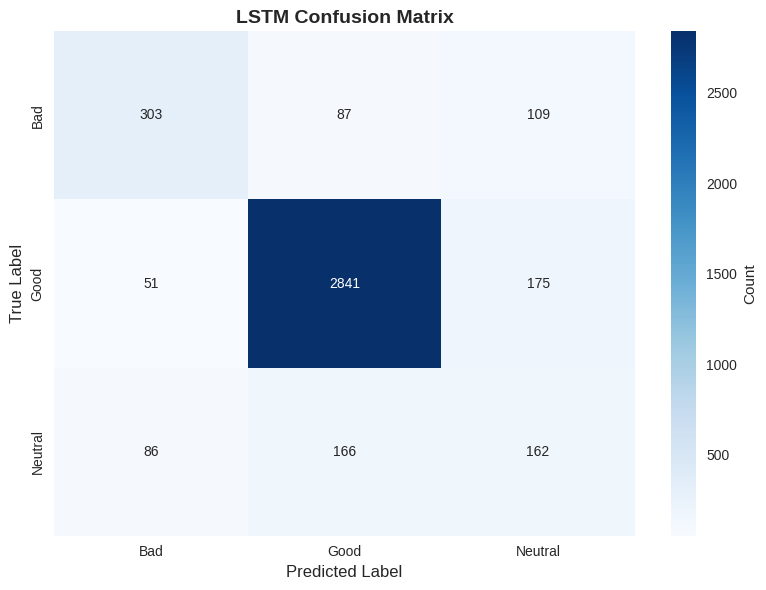

array([[ 303,   87,  109],
       [  51, 2841,  175],
       [  86,  166,  162]])

In [16]:
# Visualizations
visualizer.plot_confusion_matrix(
        y_test, lstm_results['predictions'],
        'LSTM Confusion Matrix', list(sentiment_map.values())
    )

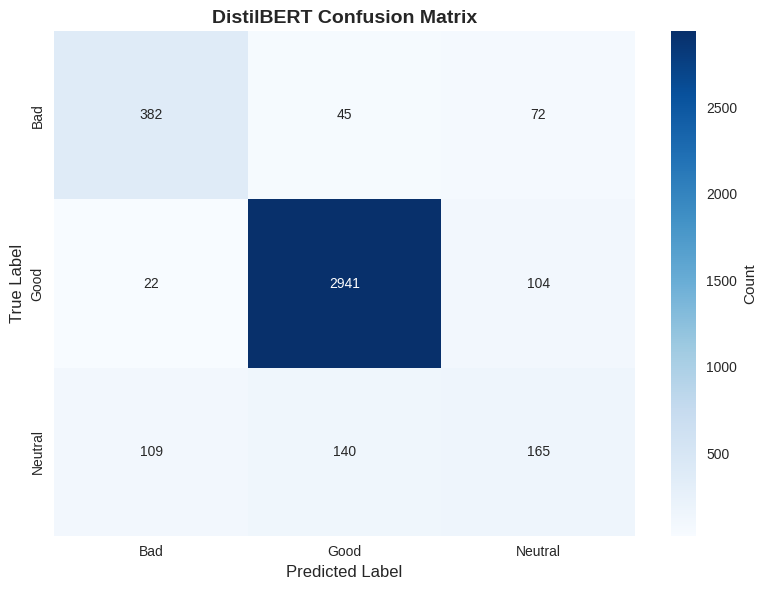

array([[ 382,   45,   72],
       [  22, 2941,  104],
       [ 109,  140,  165]])

In [17]:
visualizer.plot_confusion_matrix(
        y_test, bert_results['predictions'],
        'DistilBERT Confusion Matrix', list(sentiment_map.values())
    )

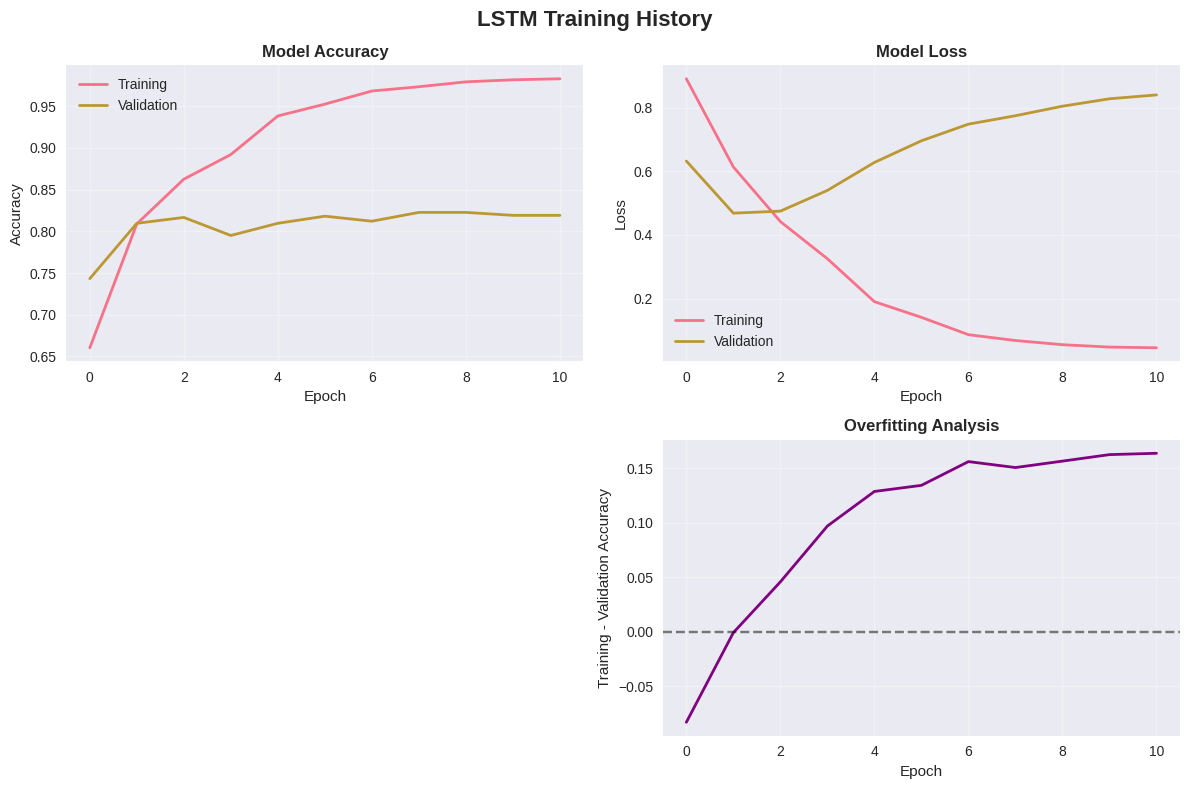

In [18]:
visualizer.plot_training_history(lstm_history, 'LSTM')

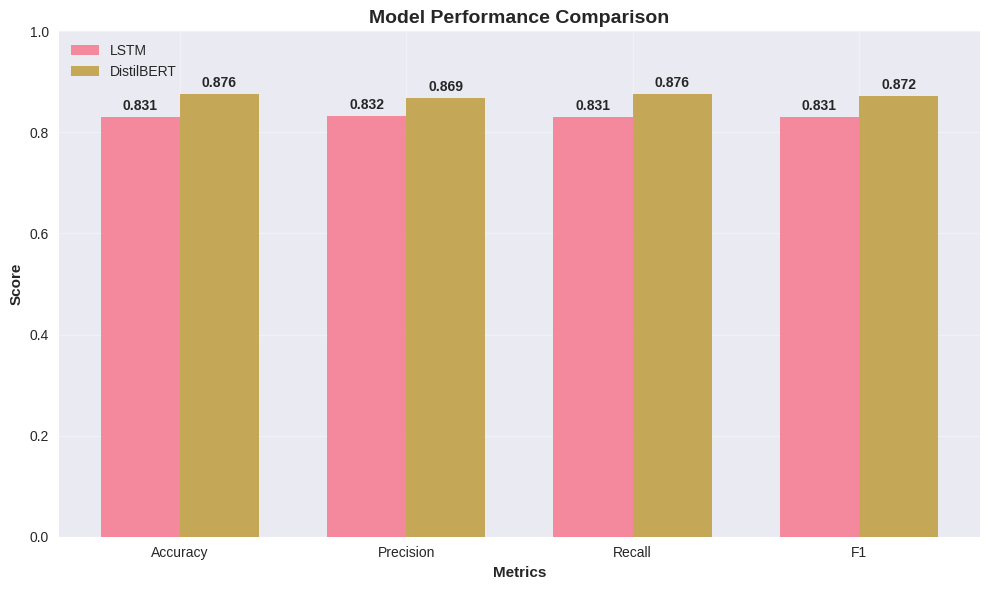

In [19]:
visualizer.plot_model_comparison(lstm_results, bert_results)